#### BERT based Sequence Labeller

We've explored training HMM (Viterbi) and RNN-based POS (part of speech) taggers on tagged sentences from the Stanford treebank dataset. We saw that the HMM tagger had a validation accuracy of about 90% and the RNN based tagger had about 91%. We will now try a different type of neural approach. For the RNN, recall that we used pretrained GloVe embeddings to represent the words in a sentence. Since the meaning of words in a sentence can be ambiguous, we should use contextualized vector representations of words instead of fixed GloVe word embeddings to overcome this problem of word sense. Pretrained BERT models are perfect for this task because they can be used to extract contextualized word embedding. 

In this notebook, we will finetune a BERT model on the POS tagging task. Since BERT uses subword tokenization and POS labels are assigned to whole words, we need to figure out a way of assigning labels to the subword tokens. A simple approach is to assign the POS label of a word to the first subword in the sequence of subwords corresponding to that word, then assign a special tag 'X' to the remaining subwords, which indicates a continuation of the preceding POS label. e.g.

`(spokesman, NN)` --> {`(spokes, NN)`, `(##man, X)`}



In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from nltk.corpus import treebank
from tqdm import tqdm
import psutil
import wandb
import os
import random

wandb.login()
print(torch.cuda.is_available())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanzids. Use `wandb login --relogin` to force relogin


True


#### Set up the dataset.

Number of sentences:  3914
Longest sentence length: 271


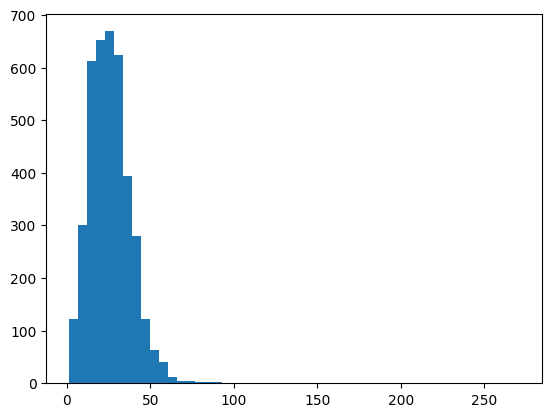

In [2]:
# get the POS tagged corpus, 3914 tagged sentences
corpus = list(treebank.tagged_sents())
# shuffle the corpus
random.seed(42)
random.shuffle(corpus)

print("Number of sentences: ", len(corpus))
print(f"Longest sentence length: {max([len(s) for s in corpus])}")

# create training-validation splits
num_train = int(0.9 * len(corpus))
train_corpus = corpus[:num_train]
val_corpus = corpus[num_train:]

 # get the sentences and labels
train_sentences = [[elem[0] for elem in s] for s in train_corpus]
train_pos_labels = [[elem[1] for elem in s] for s in train_corpus]
val_sentences = [[elem[0] for elem in s] for s in val_corpus]
val_pos_labels = [[elem[1] for elem in s] for s in val_corpus]

# define special continuation tag
continuation_tag = "X"
# get tag set
tags = sorted([continuation_tag] + list(set([elem[1] for s in corpus for elem in s])))
tag2idx = {tag:idx for idx, tag in enumerate(tags)}

# histogram of sent_lens
import matplotlib.pyplot as plt
sent_lens = [len(s) for s in corpus] 
plt.hist(sent_lens, bins=50)
plt.show()        

In [3]:
# set tokenizer parallelism to False
os.environ["TOKENIZERS_PARALLELISM"] = "false"  

class Treebank(Dataset):
    def __init__(self, sentences, pos_labels, tag2idx, continuation_tag = "X", block_size=128):
        self.block_size = block_size
        self.sentences = sentences
        self.pos_labels = pos_labels
        self.tag2idx = tag2idx
        self.continuation_tag = continuation_tag
        self.tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

    @property
    def num_tags(self):
        return len(self.tags)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # get sentence and labels
        sentence = self.sentences[idx]
        labels = self.pos_labels[idx]
        # tokenize the sentence
        input_encoding = self.tokenizer.encode_plus(sentence, is_split_into_words=True, return_offsets_mapping=False, padding=False, truncation=False, add_special_tokens=True)
        input_idx = input_encoding['input_ids']
        word_ids = input_encoding.word_ids()

        # assign labels to subword tokens (we use -100 as label for special tokens)
        labels_subword = [-100]
        for i in range(len(word_ids)):
            if word_ids[i] != None:
                if word_ids[i] != word_ids[i-1]:
                    labels_subword.append(self.tag2idx[labels[word_ids[i]]])
                else:
                    labels_subword.append(self.tag2idx[self.continuation_tag]) 
        labels_subword.append(-100)  

        # truncate the input sequence if it is too long
        if len(input_idx) > self.block_size:
            input_idx = input_idx[:self.block_size-1] + [input_idx[-1]]
            labels_subword = labels_subword[:self.block_size-1] + [labels_subword[-1]]

        # add padding 
        input_idx = input_idx + [self.tokenizer.pad_token_id] * (self.block_size - len(input_idx))    
        labels_subword = labels_subword + [-100] * (self.block_size - len(labels_subword))    
        # create attention mask 
        input_attn_mask = [1 if idx != self.tokenizer.pad_token_id else 0 for idx in input_idx]

        # convert to tensors
        input_idx = torch.tensor(input_idx)
        labels_subword = torch.tensor(labels_subword)
        input_attn_mask = torch.tensor(input_attn_mask) 
        
        return input_idx, input_attn_mask, labels_subword   

In [4]:
block_size = 128
train_dataset = Treebank(train_sentences, train_pos_labels, tag2idx, block_size=block_size)
val_dataset = Treebank(val_sentences, val_pos_labels, tag2idx, block_size=block_size)

#### Create the POS tagger model

In [5]:
class BERTPOS(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super().__init__()
        # load pretrained BERT model
        #self.bert_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.bert_encoder = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(dropout_rate)
        # define classifier head
        self.classifier_head = torch.nn.Linear(768, num_classes)
        # make sure BERT parameters are trainable
        for param in self.bert_encoder.parameters():
            param.requires_grad = True

    def forward(self, input_idx, input_attn_mask, targets=None):
        # compute BERT embeddings for input tokens
        bert_output = self.bert_encoder(input_idx, attention_mask=input_attn_mask)
        bert_output = self.dropout(bert_output.last_hidden_state) # shape: (batch_size, block_size, hidden_size)
        # compute output logits
        logits = self.classifier_head(bert_output) # shape: (batch_size, block_size, num_classes)
        loss = None  
        if targets is not None:
            # reshape logits to (batch_size * block_size, num_classes)
            logits = logits.view(-1, logits.shape[-1])
            # reshape targets to (batch_size * block_size)
            targets = targets.view(-1)
            # compute cross-entropy loss
            loss = F.cross_entropy(logits, targets, ignore_index=-100)
        return logits, loss
    

# training loop
def train(model, optimizer, train_dataloader, val_dataloader, scheduler=None, device="cpu", num_epochs=10, val_every=100, save_every=None, log_metrics=None):
    avg_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    model.train()
    # reset gradients
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        num_correct = 0
        num_total = 0
        pbar = tqdm(train_dataloader, desc="Epochs")
        for i, batch in enumerate(pbar):
            input_idx, input_attn_mask, targets = batch
            # move batch to device
            input_idx, input_attn_mask, targets = input_idx.to(device), input_attn_mask.to(device), targets.to(device)
            # forward pass
            logits, loss = model(input_idx, input_attn_mask, targets)
            # reset gradients
            optimizer.zero_grad()
            # backward pass
            loss.backward()
            # optimizer step
            optimizer.step()

            if scheduler is not None:
                    scheduler.step()

            avg_loss = 0.9* avg_loss + 0.1*loss.item()
            B, _ = input_idx.shape
            # reshape logits to (batch_size * block_size, num_classes)
            logits = logits.view(-1, logits.shape[-1])
            y_pred = logits.argmax(dim=-1).view(-1) # shape (batch_size * block_size,)
            # reshape targets
            targets = targets.view(-1) # shape (batch_size * block_size,)
            # target mask
            target_mask = (targets != -100)
            # compute accuracy
            num_correct += y_pred[target_mask].eq(targets[target_mask]).sum().item()
            num_total += target_mask.sum().item()
            train_acc = num_correct / num_total        

            if val_every is not None:
                if i%val_every == 0:
                    # compute validation loss
                    val_loss, val_acc = validation(model, val_dataloader, device=device)
                    pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            if log_metrics:
                metrics = {"Batch loss":loss.item(), "Moving Avg Loss":avg_loss, "Train Accuracy":train_acc, "Val Loss": val_loss, "Val Accuracy":val_acc}
                log_metrics(metrics)

        if save_every is not None:
            if (epoch+1) % save_every == 0:
                save_model_checkpoint(model, optimizer, epoch, avg_loss)


def validation(model, val_dataloader, device="cpu"):
    model.eval()
    val_losses = torch.zeros(len(val_dataloader))
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for i,batch in enumerate(val_dataloader):
            input_idx, input_attn_mask, targets = batch
            input_idx, input_attn_mask, targets = input_idx.to(device), input_attn_mask.to(device), targets.to(device)
            logits, loss = model(input_idx, input_attn_mask, targets)
            B, _ = input_idx.shape
            # reshape logits to (batch_size * block_size, num_classes)
            logits = logits.view(-1, logits.shape[-1])
            y_pred = logits.argmax(dim=-1).view(-1) # shape (batch_size * block_size,)
            # reshape targets
            targets = targets.view(-1) # shape (batch_size * block_size,)
            # target mask
            target_mask = (targets != -100)
            # compute accuracy
            num_correct += y_pred[target_mask].eq(targets[target_mask]).sum().item()
            num_total += target_mask.sum().item()
            val_losses[i] = loss.item()
    model.train()
    val_loss = val_losses.mean().item()
    val_accuracy = num_correct / num_total
    return val_loss, val_accuracy


def save_model_checkpoint(model, optimizer, epoch=None, loss=None, filename='BERT_tagger_checkpoint.pth'):
    # Save the model and optimizer state_dict
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    # Save the checkpoint to a file
    torch.save(checkpoint, filename)
    print(f"Saved model checkpoint!")



def load_model_checkpoint(model, optimizer=None,  filename='BERT_tagger_checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded model from checkpoint!")
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.train()
        return model, optimizer          
    else:
        return model        

In [6]:
B = 16
DEVICE = "cuda"
learning_rate = 1e-5
epochs = 5

train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)

# model with finetuning disabled
model = BERTPOS(num_classes=len(tags) ,dropout_rate=0.1).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs 
warmup_steps = int(len(train_dataloader) * 0.1 *  epochs) 
scheduler = None #get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
#model, optimizer = load_model_checkpoint(model, optimizer)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in transformer network: {num_params/1e6} M")
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters in transformer network: 124.681775 M
RAM used: 2751.11 MB


In [7]:
run = wandb.init(
    project="BERT POS Tagger", 
    config={
        "model": "RoBERTa",
        "learning_rate": learning_rate, 
        "epochs": 5,
        "batch_size": B, 
        "corpus": "Stanford Treebank"},)   

def log_metrics(metrics):
    wandb.log(metrics)

In [8]:
train(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, num_epochs=epochs, scheduler=scheduler, save_every=None, val_every=30, log_metrics=log_metrics) 

Epoch 1, EMA Train Loss: 0.417, Train Accuracy:  0.652, Val Loss:  0.286, Val Accuracy:  0.946:  69%|██████▉   | 152/221 [00:36<00:16,  4.13it/s]


KeyboardInterrupt: 